# Sudoku Puzzle Recognition

This notebook is about demonstrating the result of combining the techniques described in both the notebooks about [puzzle extracting](./Sudoku%20Puzzle%20Extractor.ipynb) and [handwritten digit recognition](Handwritten%20Digit%20Recognition.ipynb).

A `SudokuRecognition` class is defined in `model.py` which will be used here to demonstrate the combination of the two aforementioned techniques.

## Packages

In [1]:
import cv2
import matplotlib.pyplot as plt
from sudoku_recognition import SudokuRecognition

## Demonstration

The combination of both techniques performs the best when we have a clear image of a sudoku puzzle and no overlapping of digits and gridlines. In this section, I will show some of the good examples.

With today's technology, taking a clear picture of a sudoku puzzle shouldn't be an issue. (hopefully)

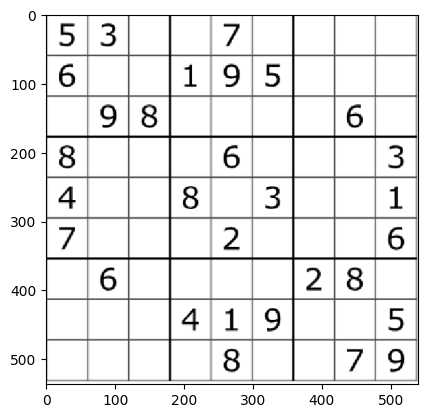

In [5]:
im = cv2.imread('test1.png')
plt.imshow(im)

In [6]:
SudokuRecognition.recognize(im)

[[5, 3, 0, 0, 7, 0, 0, 0, 0],
 [6, 0, 0, 1, 9, 5, 0, 0, 0],
 [0, 9, 8, 0, 0, 0, 0, 6, 0],
 [8, 0, 0, 0, 6, 0, 0, 0, 3],
 [4, 0, 0, 8, 0, 3, 0, 0, 1],
 [7, 0, 0, 0, 2, 0, 0, 0, 5],
 [0, 6, 0, 0, 0, 0, 2, 8, 0],
 [0, 0, 0, 4, 1, 9, 0, 0, 5],
 [0, 0, 0, 0, 8, 0, 0, 7, 9]]

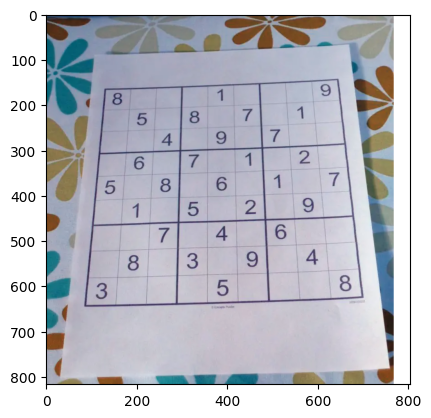

In [7]:
im = cv2.imread('test.png')
plt.imshow(im)

In [8]:
SudokuRecognition.recognize(im)

[[8, 0, 0, 0, 1, 0, 0, 0, 9],
 [0, 5, 0, 8, 0, 7, 0, 1, 0],
 [0, 0, 4, 0, 9, 0, 7, 0, 0],
 [0, 6, 0, 7, 0, 1, 0, 2, 0],
 [5, 0, 8, 0, 6, 0, 1, 0, 7],
 [0, 1, 0, 5, 0, 2, 0, 9, 0],
 [0, 0, 7, 0, 4, 0, 6, 0, 0],
 [0, 8, 0, 3, 0, 9, 0, 4, 0],
 [3, 0, 0, 0, 5, 0, 0, 0, 8]]

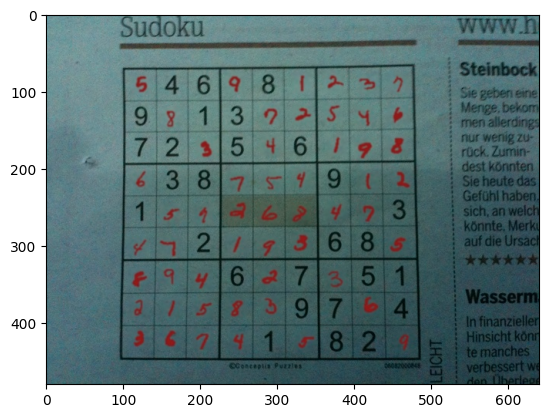

In [9]:
im = cv2.imread('./sudoku_dataset/mixed/image203.jpg')
plt.imshow(im)

In [10]:
SudokuRecognition.recognize(im)

[[5, 4, 6, 8, 8, 1, 2, 3, 3],
 [9, 8, 1, 3, 7, 2, 5, 4, 6],
 [7, 2, 3, 5, 4, 6, 1, 9, 8],
 [6, 3, 8, 7, 5, 9, 9, 1, 2],
 [1, 5, 9, 2, 6, 9, 4, 7, 3],
 [7, 9, 2, 1, 7, 3, 6, 8, 5],
 [8, 9, 4, 6, 2, 7, 3, 5, 1],
 [2, 1, 5, 8, 3, 9, 7, 4, 4],
 [3, 6, 7, 4, 1, 5, 8, 2, 9]]